# Lecture 4 - Building makemore Part 3: Activations & Gradients, BatchNorm

We dive into some of the internals of MLPs with multiple layers and scrutinize the statistics of the forward pass activations, backward pass gradients, and some of the pitfalls when they are improperly scaled. We also look at the typical diagnostic tools and visualizations you'd want to use to understand the health of your deep network. We learn why training deep neural nets can be fragile and introduce the first modern innovation that made doing so much easier: Batch Normalization. Residual connections and the Adam optimizer remain notable todos for later video.

- [YouTube video lecture](https://youtu.be/P6sfmUTpUmc)
- [Jupyter notebook files](lectures/makemore/makemore_part3_bn.ipynb)
- [makemore Github repo](https://github.com/karpathy/makemore)

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Starter code

Code from previous lectures, slightly modified but not in terms of their actual function.

- `@torch.no_grad()` : Decorator that disables gradient tracking, enabling the function to be faster.

In [2]:
# Read the data

words = open("names.txt", "r").read().splitlines()
print(f"Total number of words : {len(words)}")
print(f"A few examples :\n\t{words[:5]=}")

Total number of words : 32033
A few examples :
	words[:5]=['emma', 'olivia', 'ava', 'isabella', 'sophia']


In [3]:
# Build vocabulary and character mappings from/to ints

chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi["."] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(stoi.keys())

print(f"Vocabulary size : {vocab_size}")
print(f"{stoi=}")
print(f"{itos=}")

Vocabulary size : 27
stoi={'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
itos={1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
list("nearchos")

['n', 'e', 'a', 'r', 'c', 'h', 'o', 's']

In [5]:
# Build the dataset

block_size = 3 # Number of previous characters (data points) we consider as input to predict the next one

def build_dataset(words):
    X = []
    Y = []
    for word in words:
        word = ["."] * block_size + list(word) + ["."]
        word = [stoi[s] for s in word]
        for i in range(0, len(word) - block_size):
            X.append(word[i:i+block_size])
            Y.append(word[i+block_size])
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP revisited

n_embd = 10 # Dimensionality of character embedding vectors
n_hidden = 200 # Number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),              generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g)
b1 = torch.randn(n_hidden,                          generator=g)
W2 = torch.randn((n_hidden, vocab_size),            generator=g)
b2 = torch.randn(vocab_size,                        generator=g)

parameters = [C, W1, b1, W2, b2]
print(f"Number of parameters : {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad=True

Number of parameters : 11897


      0/ 200000: 27.8817
  10000/ 200000: 2.8598
  20000/ 200000: 2.5249
  30000/ 200000: 2.8522
  40000/ 200000: 2.0585
  50000/ 200000: 2.5718
  60000/ 200000: 2.3764
  70000/ 200000: 2.1211
  80000/ 200000: 2.2893
  90000/ 200000: 2.3247
 100000/ 200000: 2.0574
 110000/ 200000: 2.4674
 120000/ 200000: 1.9108
 130000/ 200000: 2.4755
 140000/ 200000: 2.1971
 150000/ 200000: 2.1689
 160000/ 200000: 2.1055
 170000/ 200000: 1.8050
 180000/ 200000: 2.0539
 190000/ 200000: 1.8716


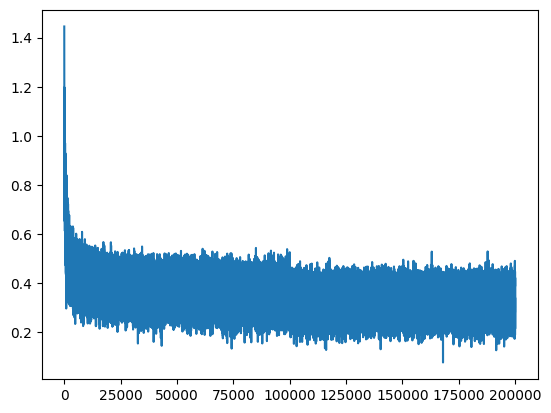

In [7]:
# Optimization

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construction
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,y

    # forward pass
    emb = C[Xb] #embed the characters into vectors
    embcat = emb.view(batch_size, n_embd * block_size) # concatenate the vectors
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
    assert embcat.shape == emb.view(emb.shape[0], -1).shape

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

plt.plot(lossi)
plt.show()

In [8]:
# Final train and validation loss

@torch.no_grad() # decorator disabling gradient tracking
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte)
        }[split]
    # forward pass
    emb = C[x]
    embcat = C[x].view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return loss

print(f"Train loss : {split_loss("train"):.4f}")
print(f"Validation loss : {split_loss("val"):.4f}")

Train loss : 2.1273
Validation loss : 2.1711


In [9]:
# Sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        
        # compute the distribution
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        out.append(ix)

        # shift context
        context = context[1:] + [ix]

        # break condition
        if ix == 0:
            break
    
    print("".join(itos[i] for i in out))


mora.
mayah.
seel.
nah.
yam.
ren.
rucendrae.
cadee.
daelin.
shy.
jen.
eden.
estanaraelyn.
malara.
noshubergihamiest.
jair.
jenipanthona.
ubelleder.
yarue.
els.


## Optimizing the Initialization

### Fixing the initial loss

Initialization is all messed up : Network is very confidently wrong (confidence: big probability for a single character).

Problem: Initial loss too big in comparison with final loss.There's $27$ characters and therefore, in a random scenario each character has $\frac{1}{27} chance of being selected. The loss in this case is about $3$ << $27$.

Solution: We want logits to be similar at first iteration. To be symmetrical we don't choose a positive or negative number but 0.

- Note 1 : Good initialization removes the "hokey stick" form of the loss. That's because it skips the first (easy) steps of the network where the network basically shrinks down its parameters to reduce the loss.

In [10]:
# Example

#logits = torch.tensor([0.0, 5, .0, 0.0, 0.0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log() # Ground truth is the one at index 2
logits, probs, loss

(tensor([  4.6030,  -2.3564,  10.0663, -10.7992]),
 tensor([4.2213e-03, 4.0092e-06, 9.9577e-01, 8.6373e-10]),
 tensor(0.0042))

In [11]:
# Expected loss for our case

print(f"Expected (uniform) loss : {-torch.tensor(1/27).log()}")

Expected (uniform) loss : 3.295836925506592


In [12]:
# Modifications purpose : Logits at first pass should be all very close to 0

## Mod 1 : logits = h @ W1 + b1 -> b1 is added to logits. Therefore, we set it to zero so it adds the same to everything => logits = h @ W1 is closer to zero
## Mod 2 : logits = h @ W1 -> The smaller W1 is, the closest to zero logits are. Therefore, we scale W1 by 0.1. Why not scale by 0, so that we actually get a uniform logits distribution ?

n_embd = 10 # Dimensionality of character embedding vectors
n_hidden = 200 # Number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),              generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g)
b1 = torch.randn(n_hidden,                          generator=g)
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn(vocab_size,                        generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(f"Number of parameters : {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad=True

Number of parameters : 11897


      0/ 200000: 3.3221
  10000/ 200000: 2.1900
  20000/ 200000: 2.4196
  30000/ 200000: 2.6067
  40000/ 200000: 2.0601
  50000/ 200000: 2.4988
  60000/ 200000: 2.3902
  70000/ 200000: 2.1344
  80000/ 200000: 2.3369
  90000/ 200000: 2.1299
 100000/ 200000: 1.8329
 110000/ 200000: 2.2053
 120000/ 200000: 1.8540
 130000/ 200000: 2.4566
 140000/ 200000: 2.1879
 150000/ 200000: 2.1118
 160000/ 200000: 1.8956
 170000/ 200000: 1.8645
 180000/ 200000: 2.0326
 190000/ 200000: 1.8417


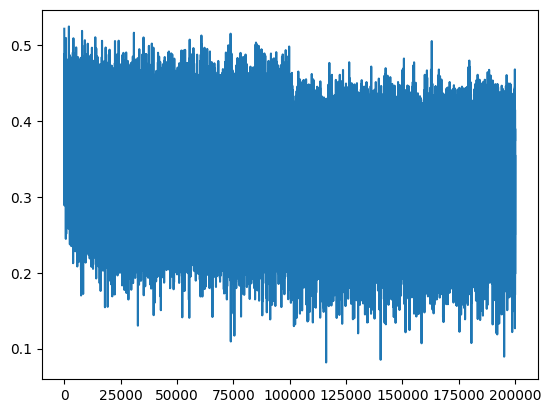

Train loss : 2.0696
Validation loss : 2.1311


In [13]:
# Optimization (No modification)

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construction
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] 
    embcat = emb.view(batch_size, n_embd * block_size) 
    hpreact = embcat @ W1 + b1 
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)
    assert embcat.shape == emb.view(emb.shape[0], -1).shape

    # Saving hn results for later
    if i == 0:
        h0 = h.detach().clone()
        hpreact0 = hpreact.detach().clone()

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
fig = plt.figure()
fig = plt.plot(lossi)
plt.show()
print(f"Train loss : {split_loss("train"):.4f}")
print(f"Validation loss : {split_loss("val"):.4f}")

### Fixing the saturated tanh

**tanh(x)** : Squashing function. It takes an arbitrarily big number and squashes it between -1 and 1.

**Observation** : After applying the $tanh$ activatioin function to our hidden layer, most values are either 1 or -1. Looking at the values of the hidden layer before the activation function this makes sense as there are a lot of big values that are squashed to $\pm 1$. $\rightarrow$ **PROBLEM**

**Problem** : When tanh is $\pm 1$ this is a problem because it's gradient is zero. Therefore, based on backpropagation all subsequent gradients will be zero. As a result all such parameters will not be updated (they'll stay the same as `p.data += lr * p.grad`). In this case we say that gradient stops flowing.

- Explanation 1 : On the plot of tanh, when tanh is $\pm 1$ we are at the flat region of the curve. We can't use that to minimize the loss.
- Explanation 2 : $\frac{d}{dx} \tanh(x) = 1 - \tanh^2(x) \rightarrow \left. \frac{d}{dx} \tanh(x) \right|_{tanh(x)=\pm 1} = 1 - 1 = 0$

**Solution** : Scale input to $tanh$ so that it's close to 0. 
- Comment : A nice distribution will still have just a very few inputs that will saturate to $\pm 1$.

**Dead Neuron** : It's possible that due to the initialization, for any example within your dataset, this neuron will output either $\pm 1$ (talking about tanh in this scenario). As a result the gradient will always be 0. So the neuron will never update. This neuron is called a "dead" one. This is a potential scenario for any activation function with a flatline eg. tanh, sigmoid, relu, elu, etc. For example, it's not possible for leaky relu as it doesn't have any flat tales/parts.


<div>
<img src="tanh.png" width="300"/>
</div>

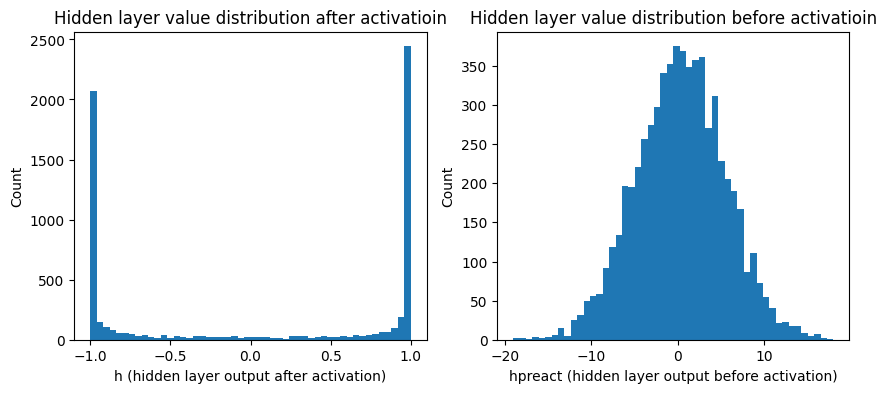

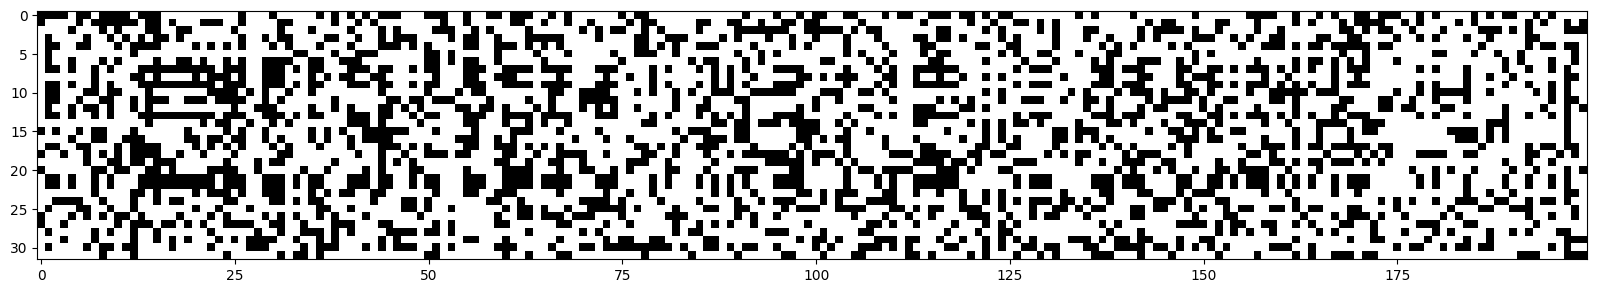

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
ax1.hist(h0.view(-1).tolist(), 50)
ax1.set_xlabel("h (hidden layer output after activation)")
ax1.set_ylabel("Count")
ax1.set_title("Hidden layer value distribution after activatioin")

ax2.hist(hpreact0.view(-1).tolist(), 50)
ax2.set_xlabel("hpreact (hidden layer output before activation)")
ax2.set_ylabel("Count")
ax2.set_title("Hidden layer value distribution before activatioin")
plt.show()

plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest") # white is True (=> not updated), black is false
plt.show()

In [15]:
# Modifications purpose : Pre-activation hidden layer (hpreact) should be close to 0 

## Mod 1 : hpreact = embcat @ W1 + b1 -> The smaller b1 is the closest hpreact will be to 0 => Scale it around 0 but not zero to maintain entropy.
## Mod 2 : hpreact = embcat @ W1 + b1 -> The smaller W1 is, the closest to 0 hpreact is. => Scale it around 0

n_embd = 10 # Dimensionality of character embedding vectors
n_hidden = 200 # Number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),              generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * 0.2  # Magic numbers -> Look Kaiming initialization below
b1 = torch.randn(n_hidden,                          generator=g) * 0.01 # Magic numbers -> Look Kaiming initialization below
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01 # Magic numbers -> Look Kaiming initialization below
b2 = torch.randn(vocab_size,                        generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(f"Number of parameters : {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad=True

Number of parameters : 11897


      0/ 200000: 3.3135
  10000/ 200000: 2.1648
  20000/ 200000: 2.3061
  30000/ 200000: 2.4541
  40000/ 200000: 1.9787
  50000/ 200000: 2.2930
  60000/ 200000: 2.4232
  70000/ 200000: 2.0680
  80000/ 200000: 2.3095
  90000/ 200000: 2.1207
 100000/ 200000: 1.8269
 110000/ 200000: 2.2045
 120000/ 200000: 1.9797
 130000/ 200000: 2.3946
 140000/ 200000: 2.1000
 150000/ 200000: 2.1948
 160000/ 200000: 1.8619
 170000/ 200000: 1.7809
 180000/ 200000: 1.9673
 190000/ 200000: 1.8295


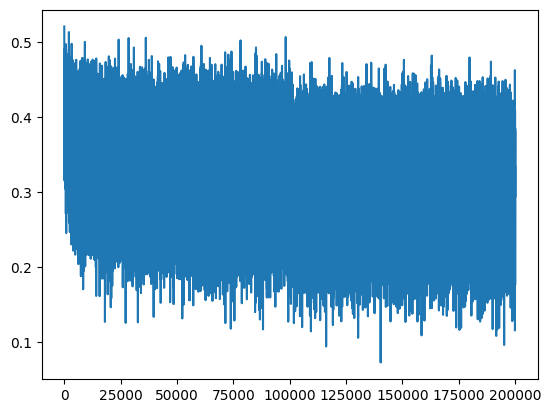

Train loss : 2.0356
Validation loss : 2.1027


In [16]:
# Optimization (No modification)

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construction
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] 
    embcat = emb.view(batch_size, n_embd * block_size) 
    hpreact = embcat @ W1 + b1 
    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)
    assert embcat.shape == emb.view(emb.shape[0], -1).shape

    # saving hn results for later
    if i == 0:
        h0 = h.detach().clone()
        hpreact0 = hpreact.detach().clone()

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
fig = plt.figure()
fig = plt.plot(lossi)
plt.show()
print(f"Train loss : {split_loss("train"):.4f}")
print(f"Validation loss : {split_loss("val"):.4f}")

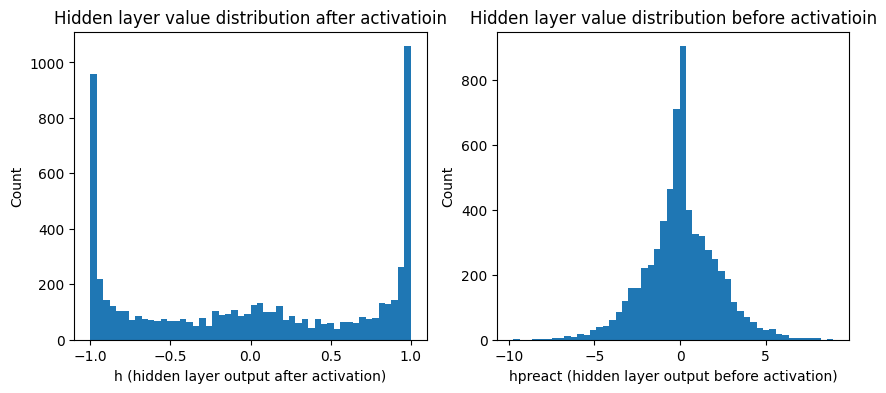

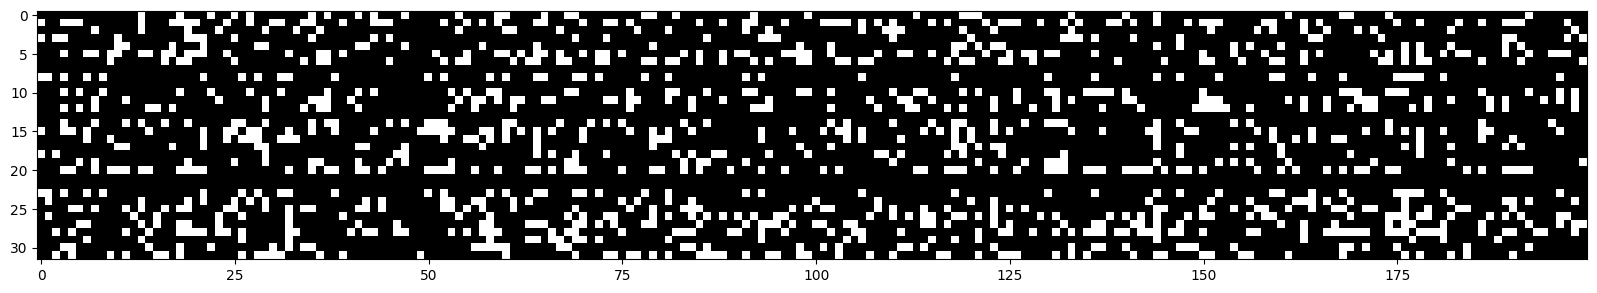

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))
ax1.hist(h.view(-1).tolist(), 50)
ax1.set_xlabel("h (hidden layer output after activation)")
ax1.set_ylabel("Count")
ax1.set_title("Hidden layer value distribution after activatioin")

ax2.hist(hpreact.view(-1).tolist(), 50)
ax2.set_xlabel("hpreact (hidden layer output before activation)")
ax2.set_ylabel("Count")
ax2.set_title("Hidden layer value distribution before activatioin")
plt.show()

plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap="gray", interpolation="nearest") # white is True (=> not updated), black is false
plt.show()

### Kaiming initialization

In the past, it was extremely important to initialize the network correctly. This was important as it allowed you to maintain good standard deviation across the network's distributions (and therfore stable activations). However, at this time multiple methods such as residual nets, normalization layers and better optimizers render the network much more stable and in this way we don't have to be exactly right when it comes to the initialization. 

- In practise : You can just normalize (divide) the weights by square root of the fan_in (number of parameters for each neuron).
- Formally : You can use kaiming initialization.

**Kaiming initialization** : When your weights are initialized using gaussian distribution then multiplying the weights with a number $\alpha$ also scales their standard deviation by $alpha$. Kaiming initialization imples initializing in this way the weights but then multiplying with the standard deviation that you want. The gain for each method is different but can be found at the top of [this](https://pytorch.org/docs/stable/nn.init.html#torch.nn.init.kaiming_normal_) page.
$\quad std = \frac{gain}{fan_mode}$

- Comment : $ std(X) = \sigma \rightarrow std(\alpha X) = \alpha \sigma,\quad \alpha \in R$

In [18]:
w = torch.empty(3, 5)
torch.nn.init.kaiming_normal_(w, mode='fan_out', nonlinearity='relu')
w.std()

tensor(0.8412)

In [19]:
# In our case: 
gain = 5/3 # because of tanh
fan_in = 30 # Hidden layer input dimensions - Parameters for each neuron

std = gain / fan_in ** 0.5
print(f"Desired std based on Kaiming : {std:.2f}")

Desired std based on Kaiming : 0.30


### Initialisation

**Original**: 
- train: 2.1273
- validation: 2.1711

**Fix softmax confidently wrong at init**: 
- train: 2.0696
- validation: 2.1311

**Fix tanh layer too saturated at init**: 
- train: 2.0356
- validation: 2.1027

## Batch Normalization

Made it possible to train deep neural nets reliably. It controls the statistics of the activations in the neural net. Common to sprinkle normalization layers after layers that have multiplications such as the linear and the convolutional.

**Inside** : You have these hidden states that you'd like their outputs to be gaussian. To achieve that just normalize them to be gaussian. You can do that as standardizing them is a derivable operation :)

**Why roughly gaussian** : Take as example tanh.
- Very small numbers : Activation almost doesn't have an effect.
- Very big numbers : Activation squashes the inptus too much.

**Normalize a distribution to gaussian** :
1. Compute its mean $\mu$.
1. Compute its std $\sigma$.
1. Subtract the mean from each element (so that new mean is zero).
1. Divide each element with the std (so the new std is one).

- Comment : When dividing with std, you can also add $\epsilon$ (very small number) to computed std to avoid division by zero.
- Comment : When you subtract the mean you essentially remove the bias for each element. Therefore, when having BN after a linear layer (or similar one such as the convolutional) there is no reason to keep the bias as it's just extra computation only. It gets taken care of with the *scale and shift* approach (below).

**Scale and shift** : Solely normalizing the outputs of each layer is not enough. That is because we keep their output distribution gaussian even though we would like to let backpropagation scale and shift this distribution as it sees fit (learn). To allow this to happen we introduce `bn_gain` (init : ones) and `bn_bias` (init : zeros) which we multiply and add to the distribution. These are new parameters through which we of course backpropagate and also update during the backward pass. This allows to have a gaussian distribution for sure in the first pass and a scaled/shifted one in the next ones.

**Problem** : Using `hpreact = bngain * (hpreact-hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True) + bnbias` implies that we use a batch. What if we want to sample just once from the model ?
- **Solution 1** : Once training is finished compute `bnmean`and `bnbias` once for the whole training set and use them onwards.
- **Solution 2** : While training, compute running `bnmean`and `bnbias`.

**Batches** : So far we just used batches just for terms of efficiency and even it that case it was done so independently. However, using BN we couple these batches mathematically in both forward and backward pass to the neural network. For example, the output (logits) of a single sample is not affected solely by the sample but also by the rest of the samples in the batch when applying BN. This turns out to be a positive side effect during the neural network training. It actually has a regulirization effect as it slightly affects the output of the sample based on the batch (introduces entropy) and therefore introduces a form of data augmentation. So by adding that noise, you make it harder for the net to overfit on specific examples.

It is important to say thought that the fact that the batch statistics are coupled to the model is not a desired effect. Other normalization methods try to avoid it.

- Random comment : For very deep networks, even though you can use relu or tanh intechangeably, relu is empirically better.

**Cost** : Coupling the batch stats to the model shoots youself on the foot as it can introduce bugs and problems. Try to avoid it. Some alternatives are group and layer normalization.

In [20]:
print(f"{hpreact.shape=} : 32 samples of 200 neurons each")
print(f"{hpreact.mean(dim=0, keepdim=True).shape=} : Mean of each neuron output across each sample of the batch")
print(f"{hpreact.std(dim=0, keepdim=True).shape=} : Standard deviation of each neuron output across each sample of the batch")

norm_hpreact = (hpreact-hpreact.mean(dim=0, keepdim=True)) / hpreact.std(dim=0, keepdim=True)
print(f"{norm_hpreact.mean(dim=0, keepdim=True).shape=} : Mean of each neuron output across each sample of the batch after normalization")
print(f"{norm_hpreact.std(dim=0, keepdim=True).shape=} : Standard deviation of each neuron output across each sample of the batch after normalization")

bn_gain = torch.ones(size=(1, 200))
bn_bias = torch.zeros(size=(1, 200))
norm_hpreact = bn_gain * norm_hpreact + bn_bias

hpreact.shape=torch.Size([32, 200]) : 32 samples of 200 neurons each
hpreact.mean(dim=0, keepdim=True).shape=torch.Size([1, 200]) : Mean of each neuron output across each sample of the batch
hpreact.std(dim=0, keepdim=True).shape=torch.Size([1, 200]) : Standard deviation of each neuron output across each sample of the batch
norm_hpreact.mean(dim=0, keepdim=True).shape=torch.Size([1, 200]) : Mean of each neuron output across each sample of the batch after normalization
norm_hpreact.std(dim=0, keepdim=True).shape=torch.Size([1, 200]) : Standard deviation of each neuron output across each sample of the batch after normalization


In [21]:
# Modifications purpose : Add gain and bias parameters for batch normalization

n_embd = 10 
n_hidden = 200 

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),              generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),   generator=g) * (5/3) / (n_embd * block_size) ** 0.5  # Updated magic numbare based on Kaiming initialization
b1 = torch.randn(n_hidden,                          generator=g) * 0.01 
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01 
b2 = torch.randn(vocab_size,                        generator=g) * 0

bngain = torch.ones(size=(1, n_hidden))
bnbias = torch.zeros(size=(1, n_hidden))

# Solution 2 : Computing running bnmean and bnstd while training
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias] # Adding BN parameters to our backward pass parameters
print(f"Number of parameters : {sum(p.nelement() for p in parameters)}")
for p in parameters:
    p.requires_grad=True

Number of parameters : 12297


      0/ 200000: 3.3147
  10000/ 200000: 2.1984
  20000/ 200000: 2.3375
  30000/ 200000: 2.4359
  40000/ 200000: 2.0119
  50000/ 200000: 2.2595
  60000/ 200000: 2.4775
  70000/ 200000: 2.1020
  80000/ 200000: 2.2788
  90000/ 200000: 2.1862
 100000/ 200000: 1.9474
 110000/ 200000: 2.3010
 120000/ 200000: 1.9837
 130000/ 200000: 2.4523
 140000/ 200000: 2.3839
 150000/ 200000: 2.1987
 160000/ 200000: 1.9733
 170000/ 200000: 1.8668
 180000/ 200000: 1.9973
 190000/ 200000: 1.8347


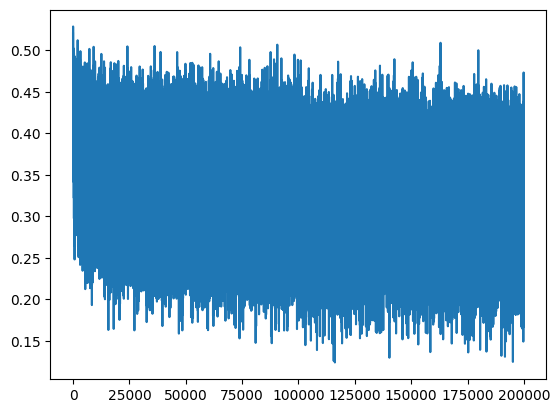

In [22]:
# Optimization - Modifications : Added batch normalization

max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # minibatch construction
    ix = torch.randint(low=0, high=Xtr.shape[0], size=(batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # forward pass
    emb = C[Xb] 
    embcat = emb.view(batch_size, n_embd * block_size) 
    hpreact = embcat @ W1 + b1
    # BatchNorm Layer
    # -------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    # Solution 2 : Computing running bnmean and bnstd while training
    with torch.no_grad():
        # 99.9% of the running values + 0.01% of the current batch values - Bit hacky but it is what it is
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # -------------------------------------------------------------

    h = torch.tanh(hpreact) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Yb)
    assert embcat.shape == emb.view(emb.shape[0], -1).shape

    # saving hn results for later
    if i == 0:
        h0 = h.detach().clone()
        hpreact0 = hpreact.detach().clone()

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
fig = plt.figure()
fig = plt.plot(lossi)
plt.show()

In [23]:
# Solution 1 : Computing bnmean and bnstd for the whole set post-training
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

In [24]:
# Final train and validation loss - Modification : Update BN to include precomputed bnmean and bnstd

@torch.no_grad() 
def split_loss(split):
    x, y = {
        "train": (Xtr, Ytr),
        "val": (Xdev, Ydev),
        "test": (Xte, Yte)
        }[split]
    # forward pass
    emb = C[x]
    embcat = C[x].view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    hpreact = bngain * (hpreact-bnmean_running) / bnstd_running + bnbias # BN
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return loss

print(f"Train loss : {split_loss("train"):.4f}")
print(f"Validation loss : {split_loss("val"):.4f}")

Train loss : 2.0666
Validation loss : 2.1051


### BN : Results summary

**Original**: 
- train: 2.1273
- validation: 2.1711

**Fix softmax confidently wrong at init**: 
- train: 2.0696
- validation: 2.1311

**Fix tanh layer too saturated at init**: 
- train: 2.0356
- validation: 2.1027

**Batch Nomralization**:
- train: 2.0666
- validation : 2.1051



## PyTorch-ifying the code

Same code written in PyTorch-inspired code.

- `self.training` : Parameter that layers which act differently on training and sampling. For example, the BN layer recomputes the running mean with the batch mean while in inference it uses the mean computed during training directly.

- Tip 1 : It could be beneficial to the initialization to make the last layer (whose results the classification is based on) less confident by scaling down its weights. To do that in the case of a linear layer you can just multiply its weight by 0.1. In the case of a BN layer you can multiply its gamma by 0.1.

- Tip 2 : Even if linear layers are kaiming initialized, remember that kaiminig initialization includes a gain that  is based on the activation function following the layer.

In [25]:
# Linear layer

class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn(size=(fan_in, fan_out), generator=g) / fan_in ** 0.5
        self.bias =  torch.zeros(fan_out)if bias else None
    
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])
    

# Batch Normalization layer

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # Parameters trained with backprop
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)

        # Buffers (parameters trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # Compute teh forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # Normalize to unit variance + avoid division by 0
        self.out = self.gamma * xhat + self.beta

        # Update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1-self.momentum) + xmean * self.momentum
                self.running_var = self.running_var * (1-self.momentum) + xvar * self.momentum
        
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    

# Tanh activation
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

n_embd = 10
n_hidden = 100 # Neurons per hidden layer
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd), generator=g)

# Without BN
layers = [
    Linear(n_embd * block_size, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size),
]

# With BN
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

with torch.no_grad():
    layers[-1].gamma *= 0.1 # Make last layer less confident
    
    # Apply gain on the weights of the layer based on activation (tanh -> 5/3)
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5 / 3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for i, p in enumerate(parameters):
    p.requires_grad = True
print(f"Number of backpropagation parameters : {sum(p.nelement() for p in parameters)}")

Number of backpropagation parameters : 47024


In [26]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2790


### Plotting the activations outputs distributions

Expectation : Distributions stabilize somewhere.

**Gain** : Using a smaller kaiming initialization gain should not stabilize the distribution while using a bigger one will stabilize it by saturating most of the values.  When using BN it shouldn't play a role.

layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.53%
layer 5 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 8 (      Tanh): mean +0.00, std 0.64, saturated: 1.97%
layer 11 (      Tanh): mean +0.00, std 0.64, saturated: 2.72%
layer 14 (      Tanh): mean -0.01, std 0.64, saturated: 2.06%


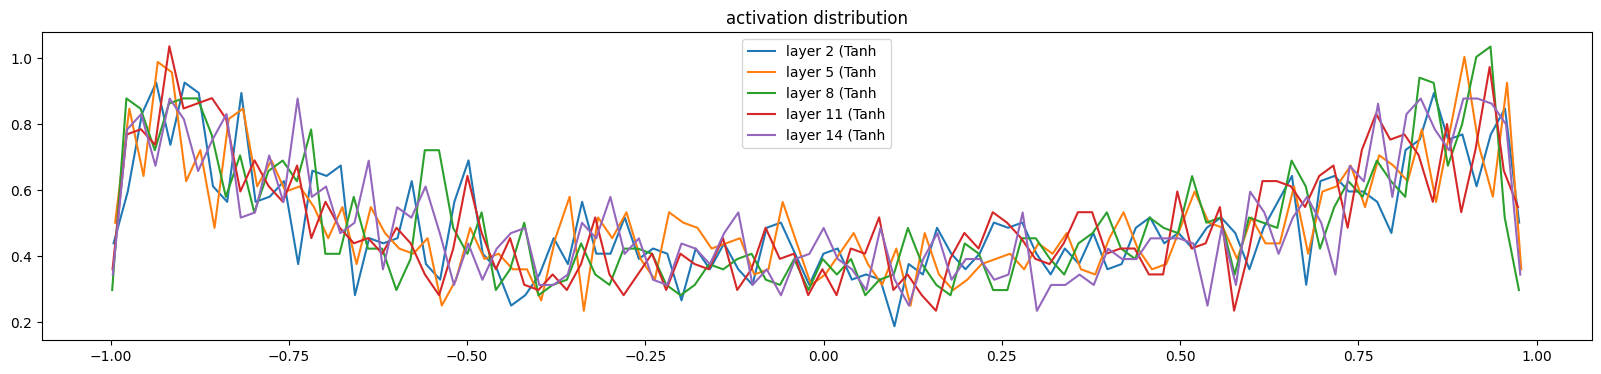

In [27]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')
plt.show()

### Plotting the activations gradient distributions

Expectation : Distributions stabilize somewhere.

**Gain** : Varying the kaiming initialization gain does not allow the activations gradient distributions to stabilize (bigger or smaller).

layer 2 (      Tanh): mean +0.000000, std 4.146130e-03
layer 5 (      Tanh): mean +0.000000, std 3.471447e-03
layer 8 (      Tanh): mean +0.000000, std 3.097052e-03
layer 11 (      Tanh): mean +0.000000, std 2.819660e-03
layer 14 (      Tanh): mean +0.000000, std 2.673055e-03


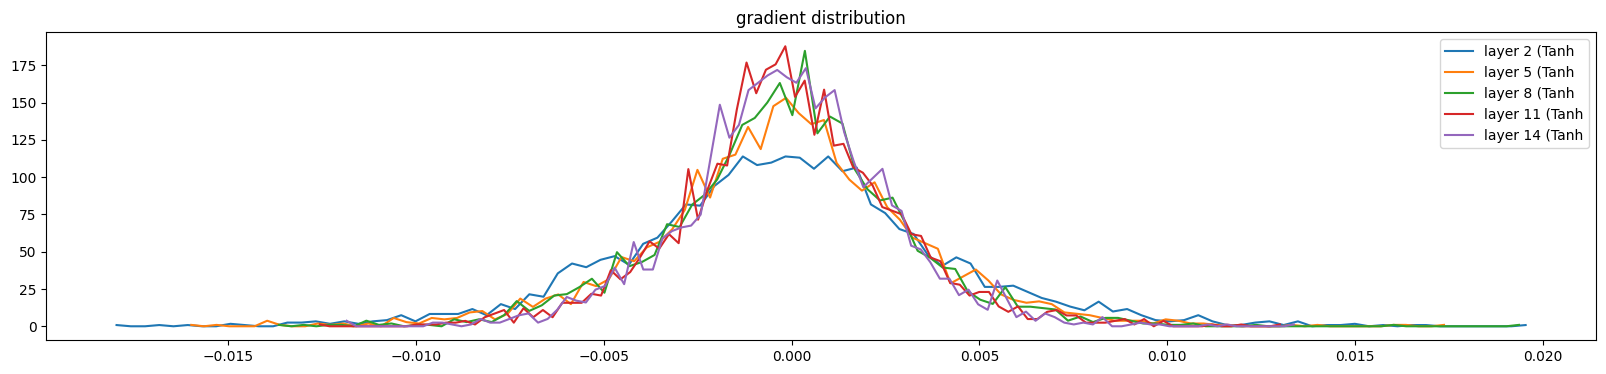

In [28]:
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')
plt.show()

## Weight gradient distribution

**Gradient to data ration** : Important statistic as when we update we use a step based on the gradient. So if gradient's magnitude are much bigger than the data we're in trouble.

weight   (27, 10) | mean +0.000000 | std 1.258774e-02 | grad:data ratio 1.257477e-02
weight  (30, 100) | mean +0.000054 | std 9.928167e-03 | grad:data ratio 3.188844e-02
weight (100, 100) | mean +0.000155 | std 8.597761e-03 | grad:data ratio 5.160579e-02
weight (100, 100) | mean +0.000077 | std 7.299911e-03 | grad:data ratio 4.325157e-02
weight (100, 100) | mean -0.000049 | std 6.680707e-03 | grad:data ratio 4.019877e-02
weight (100, 100) | mean -0.000050 | std 6.214481e-03 | grad:data ratio 3.706472e-02
weight  (100, 27) | mean +0.000034 | std 1.192147e-02 | grad:data ratio 6.962792e-02


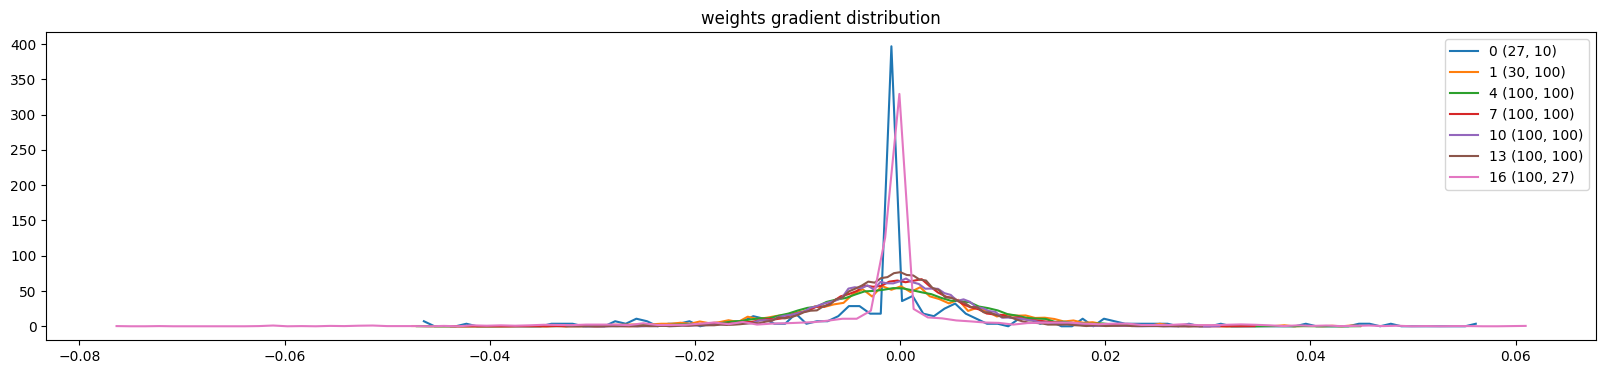

In [29]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2: # Don't plot biases
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')

plt.legend(legends)
plt.title('weights gradient distribution');
plt.show()

### Update x data ratio over time

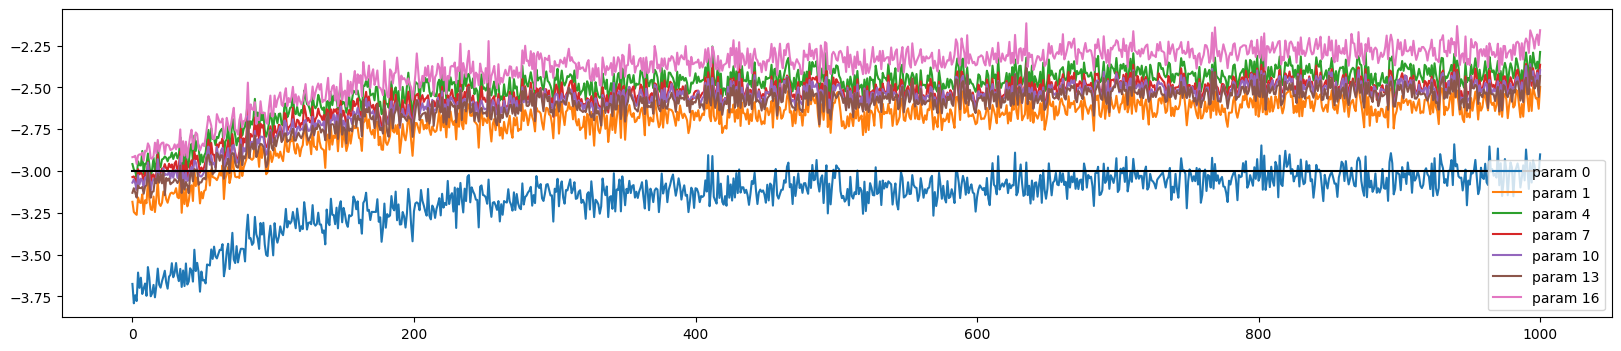

In [30]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
plt.show()

# Lecture summary

1. Introduce Batch normalization.
1. PyTor-ify the code.
1. Introduce diagnostic tools to use to undertstand whether the neural network is at a good state.